In [1]:
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
# 2차원의 다중정규분포를 따르는 난수 생성
mean1=[3,1]
sigma1=[[1,0],[0,1]]
np.random.seed(0)
N1=np.random.multivariate_normal(mean1,sigma1,1000).T
mean2=[2,2]
sigma2=[[1,0.5],[0.5,1]]
np.random.seed(1)
N2=np.random.multivariate_normal(mean2,sigma2,1000).T

In [3]:
# labeled data 생성
labeldata1={}
for i in range(100):
	labeldata1[N1[0][i],N1[1][i]]='blue'

labeldata2={}
for i in range(100):
	labeldata2[N2[0][i],N2[1][i]]='red'

In [4]:
# unlabeled data 생성
non_labeldata={}
for i in range(100,len(N1[0])):
	non_labeldata[N1[0][i],N1[1][i]]=''
	non_labeldata[N2[0][i],N2[1][i]]=''	

In [5]:
# 시각화를 위한 label, unlabeled data 키값 축출
labeldata1_key=list(labeldata1.keys())
labeldata1_x=[]
labeldata1_y=[]

labeldata2_key=list(labeldata2.keys())
labeldata2_x=[]
labeldata2_y=[]

non_labeldata_key=list(non_labeldata.keys())
non_labeldata_x=[]
non_labeldata_y=[]

for i in range(len(labeldata1_key)):
	labeldata1_x.append(labeldata1_key[i][0])
	labeldata1_y.append(labeldata1_key[i][1])
	labeldata2_x.append(labeldata2_key[i][0])
	labeldata2_y.append(labeldata2_key[i][1])

for i in range(len(non_labeldata_key)):
	non_labeldata_x.append(non_labeldata_key[i][0])
	non_labeldata_y.append(non_labeldata_key[i][1])

total_x1=labeldata1_x+non_labeldata_x
total_y1=labeldata1_y+non_labeldata_y
total_x2=labeldata2_x+non_labeldata_x
total_y2=labeldata2_y+non_labeldata_y

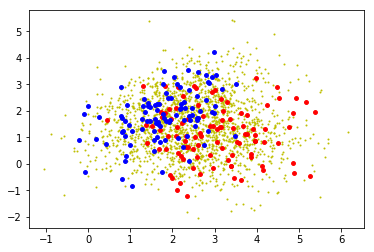

In [6]:
# label, unlabeled data 시각화
plt.scatter(non_labeldata_x,non_labeldata_y,c="y",s=1)
plt.scatter(labeldata1_x,labeldata1_y,c="r",s=15)
plt.scatter(labeldata2_x,labeldata2_y,c="b",s=15)
plt.show()

In [7]:
# EM algorithm
# labeled data의 평균과 분산
# 초기평균
mean_modal_01=[sum(labeldata1_x)/len(labeldata1_x),sum(labeldata1_y)/len(labeldata1_y)]
mean_modal_02=[sum(labeldata2_x)/len(labeldata2_x),sum(labeldata2_y)/len(labeldata2_y)]

# 초기분산
cov_modal_01=np.cov(labeldata1_x,labeldata1_y)
cov_modal_02=np.cov(labeldata2_x,labeldata2_y)

# 초기 weight
w1=0.5
w2=0.5

# Multinomail gaussian distribution function
def gaussian_pdf(x,cov):
	pdf=(1/(2*np.pi*np.sqrt(np.linalg.det(cov))))*np.exp((x.dot(np.linalg.inv(cov)).dot(np.transpose(x)))/-2)
	return pdf

# non-labeldata minus mean -> why? -> To substitute to pdf
non_labeldata_adjx=(non_labeldata_x)-(np.mean(non_labeldata_x))
non_labeldata_adjy=(non_labeldata_y)-(np.mean(non_labeldata_y))

# concatenating non-labeldata x and y 
non_labeldata_adj=np.empty([len(non_labeldata_adjx),2])
for i in range(len(non_labeldata_adjx)):
	non_labeldata_adj[i]=[non_labeldata_adjx[i],non_labeldata_adjy[i]]
# 초기 EM 알고리즘에서 사용하기 위한 설정
input_modal_01=non_labeldata_adj
input_modal_02=non_labeldata_adj

In [8]:
# EM algorithm
# E-step (expectation)
iteration=31
for a in range(iteration):
# labeldata의 parameter로 추정한 non-labeldat의 확률값
	# 대각값이 원하는 확률값(그 이외에는 (x1,y2) 등의 조합)
	# modal1에 unlabel data를 입력시 도출되는 확률	
	estimation1=gaussian_pdf(input_modal_01,cov_modal_01)
	# modal2에 unlabel data를 입력시 도출되는 확률
	estimation2=gaussian_pdf(input_modal_02,cov_modal_02)
	#가중치를 반영한 modal별 확률
	unlabeled_prob1=[]
	for i in range(len(estimation1[0])):
		unlabeled_prob1.append(estimation1[i][i])
	unlabeled_prob2=[]
	for i in range(len(estimation2[0])):
		unlabeled_prob2.append(estimation2[i][i])

# 새로운 가중치를 도출
	total=len(labeldata1_x)+len(labeldata2_x)+sum(unlabeled_prob1)+sum(unlabeled_prob2)
	w1=(len(labeldata1_x)+sum(unlabeled_prob1))/total
	w2=(len(labeldata2_x)+sum(unlabeled_prob2))/total		

# 가중치를 반영한 Unlabeled data 확률값 도출
	weighted_unlabeled_prob1=w1*np.array(unlabeled_prob1)
	weighted_unlabeled_prob2=w2*np.array(unlabeled_prob2)

# modal1, modal2를 각각 열로하고, non_labeldata를 행으로 하는 가중치 행렬생성
	weight_matrix=np.empty([len(unlabeled_prob1),2])
	for i in range(len(weighted_unlabeled_prob1)):
		weight_matrix[i][0]=(weighted_unlabeled_prob1[i])/(weighted_unlabeled_prob1[i]+weighted_unlabeled_prob2[i])
		weight_matrix[i][1]=(weighted_unlabeled_prob2[i])/(weighted_unlabeled_prob1[i]+weighted_unlabeled_prob2[i])

	total_weight_1=sum(np.transpose(weight_matrix)[0])+len(labeldata1_x)
	total_weight_2=sum(np.transpose(weight_matrix)[1])+len(labeldata2_x)

# (modal=1) weighted mean
	# label data는 해당 label에서는 확률이 1이기 때문에 단순히 합만 시행
	labeldata1_x_sum=sum(labeldata1_x)
	labeldata1_y_sum=sum(labeldata1_y)
	# modal1에서 x변수의 non labeldata의 가중치가 반영된 평균을 계산
	non_labeldata_x_1_weight=[]
	for i in range(len(non_labeldata_x)):
		non_labeldata_x_1_weight.append(non_labeldata_x[i]*weight_matrix[i][0])
	# 구한 non labeldata 확률의 합 계산
	non_labeldata_x_1_weight_sum=np.sum(non_labeldata_x_1_weight)
	# modal1에서 x변수의 새로운 평균값 도출
	newmean_x_1=(labeldata1_x_sum+non_labeldata_x_1_weight_sum)/total_weight_1
	
	# 위와 같은 과정을 y에 대하여 시행
	non_labeldata_y_1_weight=[]
	for i in range(len(non_labeldata_y)):
		non_labeldata_y_1_weight.append(non_labeldata_y[i]*weight_matrix[i][0])
	non_labeldata_y_1_weight_sum=np.sum(non_labeldata_y_1_weight)
	newmean_y_1=(labeldata1_y_sum+non_labeldata_y_1_weight_sum)/total_weight_1

# (modal=2) weighted mean
	labeldata2_x_sum=np.sum(labeldata2_x)
	labeldata2_y_sum=np.sum(labeldata2_y)
	non_labeldata_x_2_weight=[]
	for i in range(len(non_labeldata_x)):
		non_labeldata_x_2_weight.append(non_labeldata_x[i]*weight_matrix[i][1])
	non_labeldata_x_2_weight_sum=np.sum(non_labeldata_x_2_weight)
	newmean_x_2=(labeldata2_x_sum+non_labeldata_x_2_weight_sum)/total_weight_2
	non_labeldata_y_2_weight=[]
	for i in range(len(non_labeldata_y)):
		non_labeldata_y_2_weight.append(non_labeldata_y[i]*weight_matrix[i][1])
	non_labeldata_y_2_weight_sum=np.sum(non_labeldata_y_2_weight)
	newmean_y_2=(labeldata2_y_sum+non_labeldata_y_2_weight_sum)/total_weight_2

# adjusting nonlabedata by (non labeldata-newmean)
	adj_nonlabel_x_1=non_labeldata_x-newmean_x_1
	adj_nonlabel_y_1=non_labeldata_y-newmean_y_1
	adj_nonlabel_x_2=non_labeldata_x-newmean_x_2
	adj_nonlabel_y_2=non_labeldata_y-newmean_y_2

# 다음 iteration을 위한 변수값 설정
	unlabeldata_adj_modal_01=np.empty([len(adj_nonlabel_x_1),2])
	for i in range(len(adj_nonlabel_x_1)):
		unlabeldata_adj_modal_01[i]=[adj_nonlabel_x_1[i],adj_nonlabel_y_1[i]]
	unlabeldata_adj_modal_02=np.empty([len(adj_nonlabel_x_1),2])
	for i in range(len(adj_nonlabel_x_1)):
		unlabeldata_adj_modal_02[i]=[adj_nonlabel_x_2[i],adj_nonlabel_y_2[i]]
	input_modal_01=unlabeldata_adj_modal_01
	input_modal_02=unlabeldata_adj_modal_02

# weighted and adjusted nonlabedata (WA_nonlabeldata)
# modal=1
	weighted_adj_nonlabel_x_1=[]
	for i in range(len(adj_nonlabel_x_1)):
		weighted_adj_nonlabel_x_1.append(adj_nonlabel_x_1[i]*weight_matrix[i][0])
	weighted_adj_nonlabel_y_1=[]
	for i in range(len(adj_nonlabel_y_1)):
		weighted_adj_nonlabel_y_1.append(adj_nonlabel_y_1[i]*weight_matrix[i][0])
# modal=2
	weighted_adj_nonlabel_x_2=[]
	for i in range(len(adj_nonlabel_x_2)):
		weighted_adj_nonlabel_x_2.append(adj_nonlabel_x_2[i]*weight_matrix[i][1])
	weighted_adj_nonlabel_y_2=[]
	for i in range(len(adj_nonlabel_y_2)):
		weighted_adj_nonlabel_y_2.append(adj_nonlabel_y_2[i]*weight_matrix[i][1])

# labeldata-newmean
	adj_labeldata1_x=labeldata1_x-newmean_x_1
	adj_labeldata1_y=labeldata1_y-newmean_y_1
	adj_labeldata2_x=labeldata2_x-newmean_x_2
	adj_labeldata2_y=labeldata2_y-newmean_y_2

# ndarray 데이터를 list형식으로 변환
	adj_labeldata1_x=adj_labeldata1_x.tolist()
	adj_nonlabel_x_1=adj_nonlabel_x_1.tolist()
	adj_labeldata2_x=adj_labeldata2_x.tolist()
	adj_nonlabel_x_2=adj_nonlabel_x_2.tolist()
	adj_labeldata1_y=adj_labeldata1_y.tolist()
	adj_nonlabel_y_1=adj_nonlabel_y_1.tolist()
	adj_labeldata2_y=adj_labeldata2_y.tolist()
	adj_nonlabel_y_2=adj_nonlabel_y_2.tolist()

# merging WA_nonlabeldata and labeldata
# 각 변수별 label과 non label 합치기
	adj_weight_total_x_1=adj_labeldata1_x+weighted_adj_nonlabel_x_1
	adj_weight_total_y_1=adj_labeldata1_y+weighted_adj_nonlabel_y_1
	adj_weight_total_x_2=adj_labeldata2_x+weighted_adj_nonlabel_x_2
	adj_weight_total_y_2=adj_labeldata2_y+weighted_adj_nonlabel_y_2
# modal별 weigthed data x와 y 합치기
# modal1
	adj_weight_total_1=[]
	for i in range(len(adj_weight_total_x_1)):
		adj_weight_total_1.append([adj_weight_total_x_1[i],adj_weight_total_y_1[i]])
	adj_weight_total_1=np.array(adj_weight_total_1)
# modal2
	adj_weight_total_2=[]
	for i in range(len(adj_weight_total_x_2)):
		adj_weight_total_2.append([adj_weight_total_x_2[i],adj_weight_total_y_2[i]])
	adj_weight_total_2=np.array(adj_weight_total_2)

# non weighted data
	adj_total_x_1=adj_labeldata1_x+adj_nonlabel_x_1
	adj_total_y_1=adj_labeldata1_y+adj_nonlabel_y_1
	adj_total_x_2=adj_labeldata2_x+adj_nonlabel_x_2
	adj_total_y_2=adj_labeldata2_y+adj_nonlabel_y_2
# modal별 data x와 y 합치기
# modal1
	adj_total_1=[]
	for i in range(len(adj_total_x_1)):
		adj_total_1.append([adj_total_x_1[i],adj_total_y_1[i]])
	adj_total_1=np.array(adj_total_1)
# modal2
	adj_total_2=[]
	for i in range(len(adj_total_x_2)):
		adj_total_2.append([adj_total_x_2[i],adj_total_y_2[i]])
	adj_total_2=np.array(adj_total_2)

# weighted와 non weighted의 곱
	cov_product_1=(np.transpose(adj_weight_total_1)).dot(adj_total_1)
	cov_product_2=(np.transpose(adj_weight_total_2)).dot(adj_total_2)
	adj_cov_1=cov_product_1/total_weight_1
	adj_cov_2=cov_product_2/total_weight_2
	cov_modal_01=adj_cov_1
	cov_modal_02=adj_cov_2

	print("----------------------- ","iteration  ",a," -----------------------",sep="")	
	print ("At E-step, weight is ",w1,"|",w2,sep="")
	print ("At M-step, mean of modal_01 is  ",newmean_x_1," | ",newmean_y_1,sep="")
	print ("At M-step, mean of modal_02 is ",newmean_x_2," | ",newmean_y_2,sep="")
	print ("covarianve of modal_01 is")
	print (cov_modal_01)
	print ("covarianve of modal_02 is")
	print (cov_modal_02)

----------------------- iteration  0 -----------------------
At E-step, weight is 0.484305676072|0.515694323928
At M-step, mean of modal_01 is  2.5522623548 | 1.40677099526
At M-step, mean of modal_02 is 2.36311423043 | 1.57619153945
covarianve of modal_01 is
[[ 1.50301491 -0.26676152]
 [-0.26676152  1.36782353]]
covarianve of modal_02 is
[[ 0.88591427  0.32076239]
 [ 0.32076239  1.09590957]]
----------------------- iteration  1 -----------------------
At E-step, weight is 0.47659581053|0.52340418947
At M-step, mean of modal_01 is  2.65070629521 | 1.32183730178
At M-step, mean of modal_02 is 2.28809103003 | 1.64028825563
covarianve of modal_01 is
[[ 1.45178386 -0.25656987]
 [-0.25656987  1.32152193]]
covarianve of modal_02 is
[[ 0.95045871  0.29244881]
 [ 0.29244881  1.13207942]]
----------------------- iteration  2 -----------------------
At E-step, weight is 0.481130381539|0.518869618461
At M-step, mean of modal_01 is  2.71691823934 | 1.26591583994
At M-step, mean of modal_02 is 2.22

----------------------- iteration  21 -----------------------
At E-step, weight is 0.494782045959|0.505217954041
At M-step, mean of modal_01 is  2.99584780412 | 1.01790905919
At M-step, mean of modal_02 is 1.93698846437 | 1.94944827689
covarianve of modal_01 is
[[ 0.95559036 -0.00634164]
 [-0.00634164  0.98676099]]
covarianve of modal_02 is
[[ 0.94065975  0.48891713]
 [ 0.48891713  1.07924482]]
----------------------- iteration  22 -----------------------
At E-step, weight is 0.49476835727|0.50523164273
At M-step, mean of modal_01 is  2.99665306409 | 1.0169236281
At M-step, mean of modal_02 is 1.93623063335 | 1.9503908622
covarianve of modal_01 is
[[ 0.95457558 -0.00499829]
 [-0.00499829  0.98567007]]
covarianve of modal_02 is
[[ 0.94001818  0.48930521]
 [ 0.48930521  1.0785333 ]]
----------------------- iteration  23 -----------------------
At E-step, weight is 0.494757519084|0.505242480916
At M-step, mean of modal_01 is  2.997270433 | 1.01614698027
At M-step, mean of modal_02 is 1.93

In [9]:
print("----------------------- ","exact solution"," -----------------------",sep="")
print(mean1,"|",mean2)
print(sigma1)
print(sigma2)

----------------------- exact solution -----------------------
[3, 1] | [2, 2]
[[1, 0], [0, 1]]
[[1, 0.5], [0.5, 1]]


In [10]:
delta = 0.01
x = np.arange(-8.0, 5.0, delta)
y = np.arange(-2.0, 7.0, delta)
X, Y = np.meshgrid(x, y)
# modal 1의 분산
sigma_x_01=np.sqrt(cov_modal_01[0][0])
sigma_y_01=np.sqrt(cov_modal_01[1][1])
sigma_xy_01=np.sqrt(-cov_modal_01[0][1])
# modal 2의 분산
sigma_x_02=np.sqrt(cov_modal_02[0][0])
sigma_y_02=np.sqrt(cov_modal_02[1][1])
sigma_xy_02=np.sqrt(cov_modal_02[0][1])
Z1 = matplotlib.mlab.bivariate_normal(X, Y, sigma_x_01, sigma_y_01, newmean_x_1, newmean_y_1, sigma_xy_01)
Z2 = matplotlib.mlab.bivariate_normal(X, Y, sigma_x_02, sigma_y_02, newmean_x_2, newmean_y_2, sigma_xy_02)
Z = 10.0 * (Z2 - Z1)

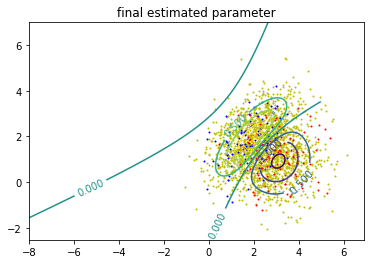

In [11]:
plt.figure()
CS = matplotlib.pyplot.contour(X, Y, Z)
plt.clabel(CS, inline=0.01, fontsize=10)
plt.title('final estimated parameter')
plt.scatter(non_labeldata_x,non_labeldata_y,c="y",s=1)
plt.scatter(labeldata1_x,labeldata1_y,c="r",s=1)
plt.scatter(labeldata2_x,labeldata2_y,c="b",s=1)
plt.show()